# **Capitulo 6 – Ensemble Learning and Random Forests**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Y vamos a crear la carpeta `images/ensembles` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este Notebook para guardar las figuras:

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [8]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Random Patches and Random Subspaces

La clase BaggingClassifier también admite el muestreo de las características. El muestreo se controla mediante dos hiperparámetros: max_features y bootstrap_features. Funcionan del mismo modo que max_sample y bootstrap, pero para el muestreo de características en lugar del muestreo de instancias. Así, cada predictor se entrenará con un subconjunto aleatorio de las características de entrada.

Esta técnica es especialmente útil cuando se trabaja con entradas de alta dimensión (como imágenes), ya que puede acelerar considerablemente el entrenamiento. El muestreo tanto de las instancias de entrenamiento como de las características se denomina método de parches aleatorios. Mantener todas las instancias de entrenamiento (estableciendo bootstrap=False y max_samples=1.0) pero muestrear las características (estableciendo bootstrap_features a True y/o max_features a un valor menor que 1.0) se denomina método de subespacios aleatorios.

El muestreo de características da como resultado una mayor diversidad de predictores, cambiando un poco más de sesgo por una menor varianza.

# Random Forests

Como ya hemos comentado, un random forest es un conjunto de árboles de decisión, generalmente entrenados mediante el método bagging (o a veces pasting), normalmente con max_samples fijado al tamaño del conjunto de entrenamiento. En lugar de construir un BaggingClassifier y pasarle un DecisionTreeClassifier, puedes usar la clase RandomForestClassifier, que es más conveniente y está optimizada para árboles de decisión (de forma similar, hay una clase RandomForestRegressor para tareas de regresión). El siguiente código entrena un clasificador de Random Forest con 500 árboles, cada uno limitado a un máximo de 16 nodos hoja, utilizando todos los núcleos de CPU disponibles:


In [6]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

Con algunas excepciones, un RandomForestClassifier tiene todos los hiperparámetros de un DecisionTreeClassifier (para controlar cómo crecen los árboles), además de todos los hiperparámetros de un BaggingClassifier para controlar el conjunto en sí.

El algoritmo de random forest introduce una aleatoriedad adicional en el crecimiento de los árboles; en lugar de buscar la mejor característica al dividir un nodo, busca la mejor característica entre un subconjunto aleatorio de características. Por defecto, muestrea n características (donde n es el número total de características). El algoritmo da como resultado una mayor diversidad del árbol, que (de nuevo) cambia un mayor sesgo por una menor varianza, lo que generalmente produce un modelo globalmente mejor. Así pues, el siguiente ClasificadorBolsa es equivalente al anterior RandomForestClassifier:

Un Random Forest equivale a una bolsa de árboles de decisión:

In [5]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

NameError: name 'DecisionTreeClassifier' is not defined

In [7]:
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)

NameError: name 'bag_clf' is not defined

## Extra-Trees

Cuando se hace crecer un árbol en un random forest, en cada nodo sólo se considera un subconjunto aleatorio de las características para la división (como se ha comentado antes). Es posible hacer árboles aún más aleatorios utilizando también umbrales aleatorios para cada característica en lugar de buscar los mejores umbrales posibles (como hacen los árboles de decisión normales). Para ello, basta con establecer splitter="random" al crear un DecisionTreeClassifier.

Un bosque de estos árboles extremadamente aleatorios se denomina conjunto de árboles extremadamente aleatorios (o extra-árboles para abreviar). Una vez más, esta técnica cambia un mayor sesgo por una menor varianza. También hace que los clasificadores extra-árboles sean mucho más rápidos de entrenar que los random forest normales, porque encontrar el mejor umbral posible para cada característica en cada nodo es una de las tareas que más tiempo consume en el crecimiento de un árbol. Puede crear un clasificador extra-trees utilizando la clase ExtraTreesClassifier de Scikit-Learn. Su API es idéntica a la de la clase RandomForestClassifier, excepto que el valor predeterminado de bootstrap es False. Del mismo modo, la clase ExtraTreesRegressor tiene la misma API que la clase RandomForestRegressor, excepto que el valor predeterminado de bootstrap es False.


Es difícil saber de antemano si un RandomForestClassifier funcionará mejor o peor que un ExtraTreesClassifier. Por lo general, la única forma de saberlo es probar ambos y compararlos mediante cross validation.

## Feature Importance

Otra gran cualidad de los Random Forest es que facilitan la medición de la importancia relativa de cada característica. Scikit-Learn mide la importancia de una característica observando en qué medida los nodos del árbol que utilizan esa característica reducen la impureza de media, en todos los árboles del bosque. Más concretamente, se trata de una media ponderada, en la que el peso de cada nodo es igual al número de muestras de entrenamiento asociadas a él.

Scikit-Learn calcula esta puntuación automáticamente para cada característica después del entrenamiento, y luego escala los resultados para que la suma de todas las importancias sea igual a 1. Puede acceder al resultado utilizando la variable feature_importances_. Por ejemplo, el siguiente código entrena un RandomForestClassifier en el conjunto de datos del iris y muestra la importancia de cada característica. Parece que las características más importantes son la longitud (44%) y la anchura (42%) de los pétalos, mientras que la longitud y la anchura de los sépalos son poco importantes en comparación (11% y 2%, respectivamente):

In [9]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


Del mismo modo, si se entrena un clasificador de random forest en el conjunto de datos MNIST y se representa gráficamente la importancia de cada píxel, se obtiene la imagen representada en la Figura.

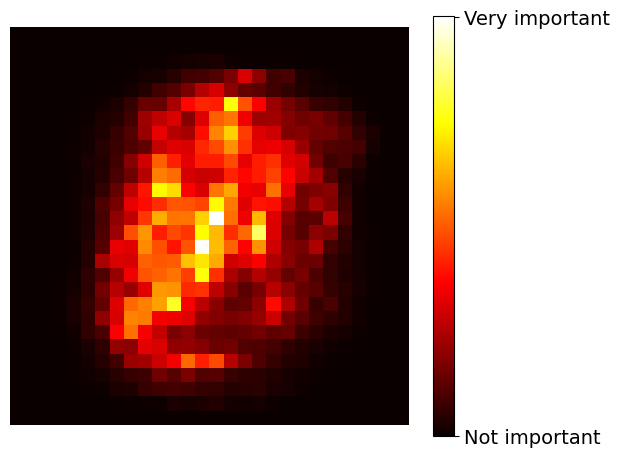

In [10]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

Los random forest son muy útiles para comprender rápidamente qué características son realmente importantes, en particular si necesita realizar una selección de características.